In [1]:
from pandas.io.json import json_normalize
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
from plotly import tools
import plotly.plotly as py
import sklearn.preprocessing as preprocessing
# plotly.tools.set_credentials_file(username='BaiTong', api_key='cDMbB7dbp8dWqweRwTYt')
def load_df(csv_path='/home/baitong/pywork/RevenuePrediction/all/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
#     print(df.head())
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [2]:
%%time
train_df = load_df()
test_df = load_df("/home/baitong/pywork/RevenuePrediction/all/test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 3min 52s, sys: 4.86 s, total: 3min 56s
Wall time: 4min 28s


In [3]:
# tmp = train_df.copy()
# tmp.head()
# print('*')
train_df.to_csv("/home/baitong/pywork/RevenuePrediction/all/Df_train.csv")
test_df.to_csv("/home/baitong/pywork/RevenuePrediction/all/test_df.csv")

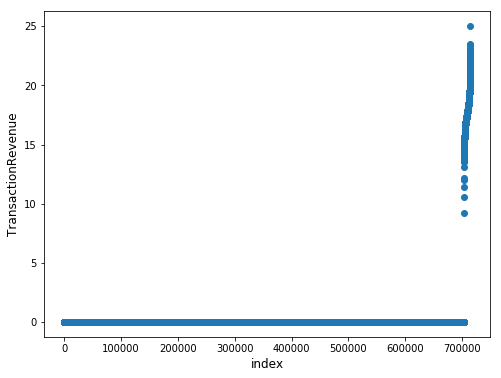

In [4]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
# gdf.to_csv("/home/baitong/pywork/RevenuePrediction/all/gdf_groupby.csv")
plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()
# print(gdf.head())

In [5]:
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


In [6]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  714167  out of rows :  903653
Number of unique visitors in test set :  617242  out of rows :  804684
Number of common visitors in train and test set :  7679


In [7]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols


['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [8]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'v',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~BaiTong/0 or inside your plot.ly account where it is named 'device-plots'


In [9]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [10]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = test_df.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In [11]:
# Continent
cnt_srs = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [12]:
# Continent
cnt_srs = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [13]:
# Page views
cnt_srs = train_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [14]:
print("Variables not in test but in train : ", set(train_df.columns).difference(set(test_df.columns)))

Variables not in test but in train :  {'totals.transactionRevenue', 'trafficSource.campaignCode'}


In [15]:
cols_to_drop = const_cols + ['sessionId']

train_df = train_df.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)


In [32]:
# Impute 0 for missing target values
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_df["totals.bounces"].fillna(0, inplace=True)
train_df["totals.newVisits"].fillna(0, inplace=True)
# predic1 = train_df[train_df['totals.pageviews'].isnull()]['totals.hits'].values
# train_df.loc[(train_df['totals.pageviews'].isnull()),'totals.pageviews' ] = predic1

test_df["totals.bounces"].fillna(0, inplace=True)
test_df["totals.newVisits"].fillna(0, inplace=True)
# predic2 = test_df[test_df['totals.pageviews'].isnull()]['totals.hits'].values
# test_df.loc[(test_df['totals.pageviews'].isnull()),'totals.pageviews' ] = predic2


train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values


# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']

for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']
# num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces']
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date']<=datetime.date(2017,5,31)]
val_df = train_df[train_df['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 
# print(num_cols+cat_cols)

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [33]:
# print(dev_X["channelGrouping"].value_counts())
# dev_X.to_csv("/home/baitong/pywork/RevenuePrediction/all/valid_col_dev_X.csv")

import lightgbm as lgb
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
   
    lgtrain = lgb.Dataset(train_X, label=train_y )
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70027
[200]	valid_0's rmse: 1.69605
[300]	valid_0's rmse: 1.69538
Early stopping, best iteration is:
[238]	valid_0's rmse: 1.69482


In [34]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.714265908308787


In [36]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("submission.csv", index=False)

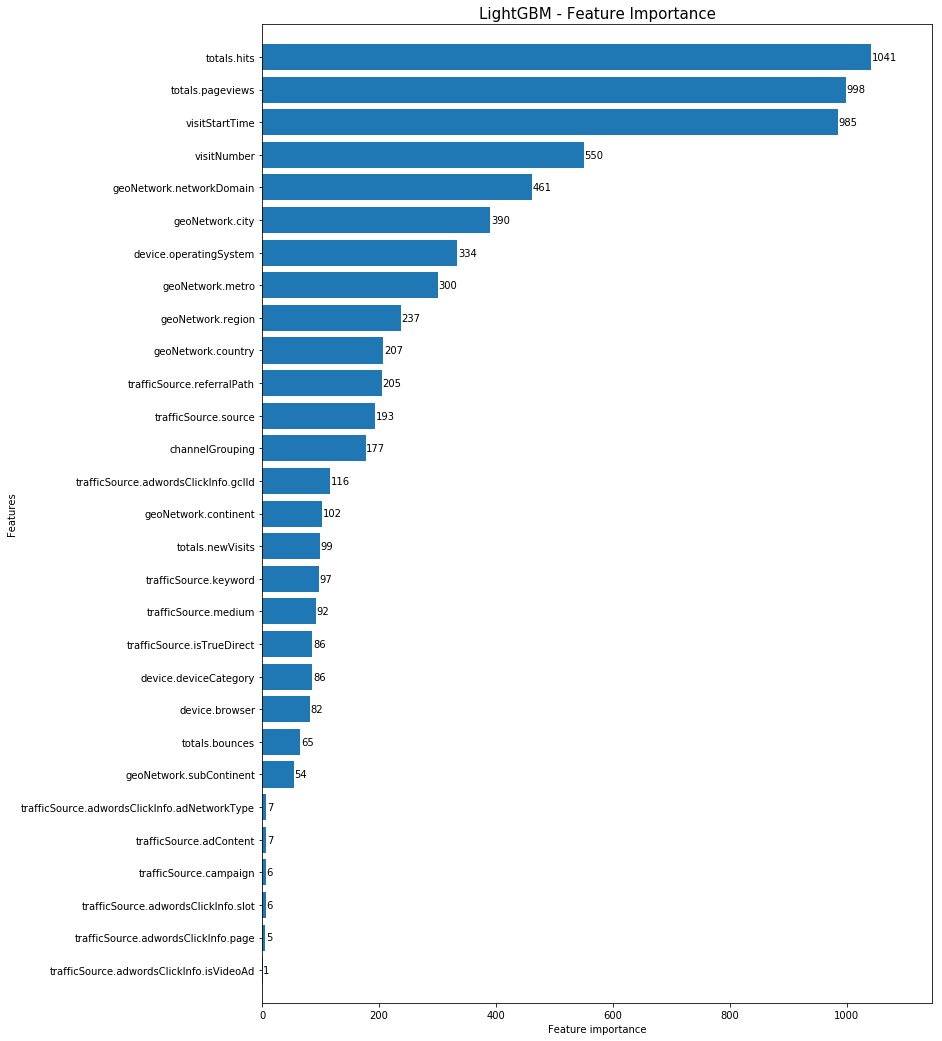

In [30]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()